In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
import glob
import seaborn as sns
import pylib
from multiprocessing import Pool

plt.rcParams.update({'font.size': 36})

Error.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (64)

In [2]:
main_load_folder = './data'


# the path for loading the fightbout info
fightBouts_info_path = os.path.join(main_load_folder, 'fightBouts.h5')

with h5py.File(fightBouts_info_path, 'r') as hf:
    fight_bout_info = hf['fight_bout_info'][:]
    fight_bout_info_noDurThresh = hf['fight_bout_info_noDurThresh'][:]
    

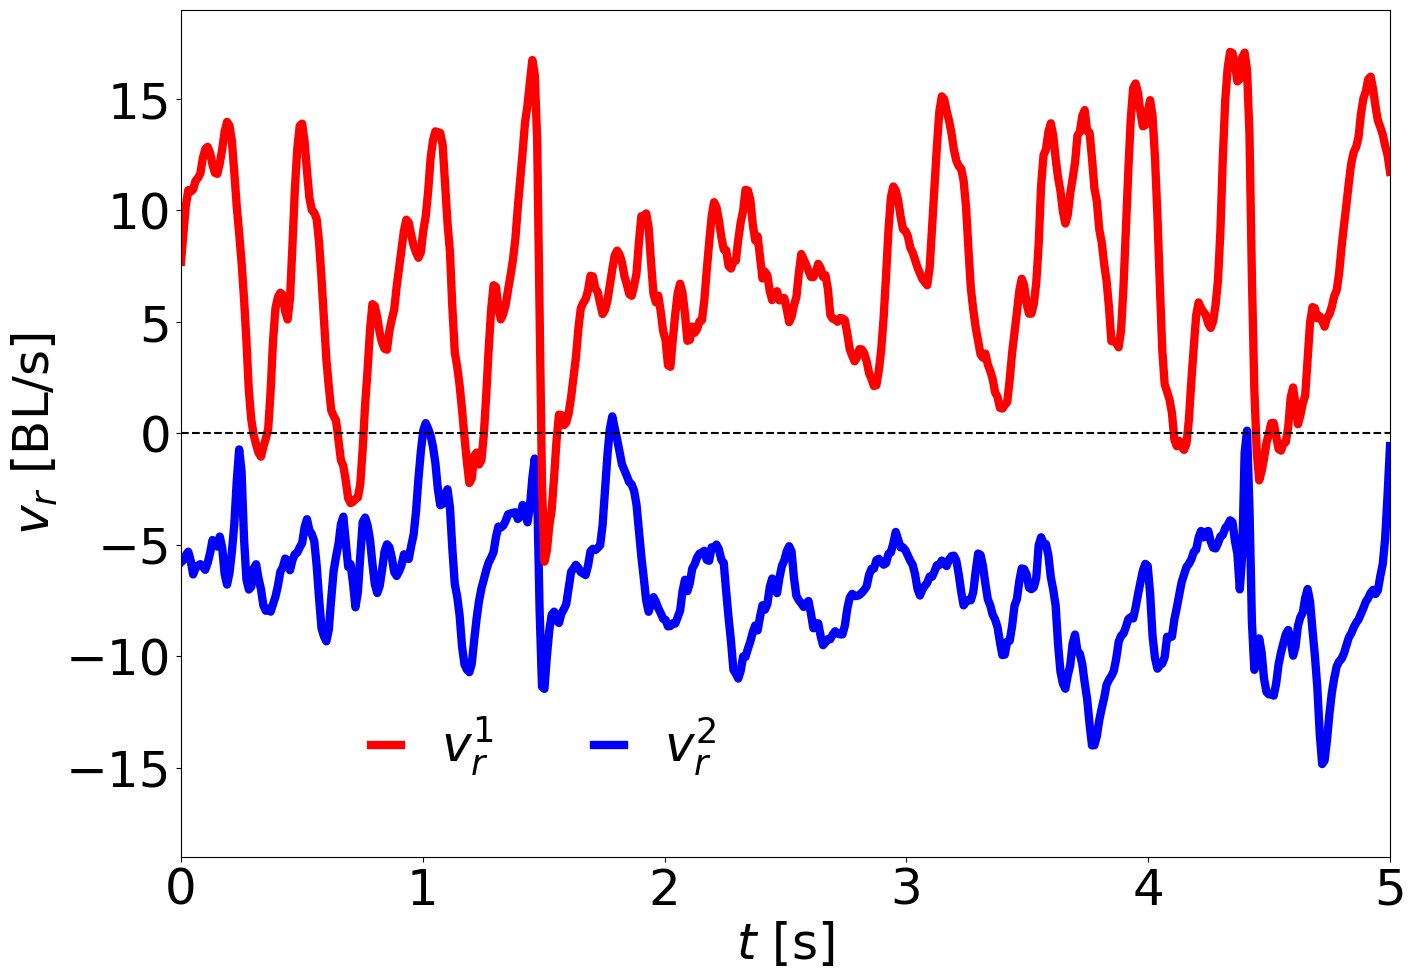

In [3]:
expid = 3
filename = './data/v_3_'+str(expid) # smoothed data
vs = np.load(filename+'.npy',allow_pickle=1)
v_1, v_2 = vs[0],vs[1]#vs[0]/bl,vs[1]/bl

fs = fight_bout_info[np.where(fight_bout_info.T[0]==expid)][0,1]
fe = fight_bout_info[np.where(fight_bout_info.T[0]==expid)][0,2]

T = fe + 304*100 - 90

# T = fight_start-41520 #1300
tau = 500
time = np.linspace(0,tau,tau*1)/100

plt.figure(figsize=[13*1.2,10*1.1])
plt.plot(time,v_2[T:T+tau,0],c='b',lw=6.,label='$v^2_r$')
plt.plot(time,v_1[T:T+tau,0],c='r',lw=6.,label='$v^1_r$')
plt.ylim([-19,19])
plt.xlim([0,5])
plt.axhline(0,c='k',ls='--')

plt.xlabel('$t$ [s]')
plt.ylabel('$v_r$ [BL/s]')
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],handlelength=.6,framealpha=0.,bbox_to_anchor=(.62, .28), ncol=2) 
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],handlelength=.6,framealpha=0.,bbox_to_anchor=(.48, .22), ncol=2) 

plt.show()

In [4]:
# ------ functions for windowed distributions ---- #

def return_overlapping_windows_for_timeframes(numFrames, window_size=200, window_step=50):
    ''' Given a number of frames, return an 2D array of window start-stop frames.
    '''
    # define, for clarity, the first window
    win0_start = 0
    win0_mid = int(window_size/2)
    win0_end = int(window_size)

    # find numWindows, by adding incrementally and watching the last frame
    last_frame_in_windows = win0_end
    numWindows = 1
    while last_frame_in_windows < (numFrames - window_step):
        numWindows += 1
        last_frame_in_windows = win0_end + (numWindows-1)*window_step

    # now fill-in the windows array of frame indices
    windows = np.zeros((numWindows, 2))
    windows[0, 0] = 0
    windows[0, 1] = win0_end
    for winIdx in range(1, numWindows):
        w0 = winIdx*window_step
        wF = w0 + window_size
        windows[winIdx, 0] = w0
        windows[winIdx, 1] = wF
    return windows.astype(int)




def compute_windowed_distribution_array_from_1D_tseries(tseries, time_windows, spatial_bins):
    ''' Create the x=time, y=var, windowed distribution array for the given tseries.

    -- args --
    tseries: a 1D timeseries
    time_windows: a (N,2) array of start-stop frames i.e the xbins
    spatial_bins: a 1D array of bins in normal format (np.arange(start,stop,step)),
                  i.e. the ybins

    -- returns --
    ts_windowed_data: shape(numBins, numWins)


    -- Note --
    the sns.heatmap outlook indexing is like

    0 1 2 ..
    1
    2
   ...

   But we want y to run the opposite way, like a traditional graph ymin to ymax.
   So what we will do is reverse the histogram values for each window as we record,
   and also swap the ylabels to match everything up.

   '''

    # -- parse some shapes -- #
    numWins = time_windows.shape[0]
    # bins array is edges, so 1 longer than values array, hence the -1
    numBins = spatial_bins.shape[0] - 1
    bin_size = np.abs(spatial_bins[1] - spatial_bins[0])
    bin_min = spatial_bins[0]
    bin_max = spatial_bins[-1]

    # -- compute the distribution --#
    # np.histogram returns bins, which are bin edges, and values in the bins
    # so bins array is 1 longer than values array, hence the -1 in ts_windowed_data shape
    ts_windowed_data = np.zeros((numBins, numWins))
    for winIdx in range(numWins):
        f0, fE = time_windows[winIdx]
        windowed_data = tseries[f0:fE]
        histvals, _ = np.histogram(windowed_data, bins=spatial_bins)
        histvals = histvals/np.sum(histvals)
        # now record the histvals backwards, so binmax appears at the top of the figure
        ts_windowed_data[:, winIdx] = histvals[::-1]

    return ts_windowed_data




def plot_windowed_distribution_array_onto_axis(ts_windowed_data, axs, spatial_bins, time_windows, vmax=600, use_cbar=False, cmap='coolwarm',
                                               xlabel='', ylabel='', plot_title='', num_xticks=6, lastPanel=False, special_ticks=[],
                                               draw_median=False,xlim=None):
    ''' Create a heatmap of the ts_windowed_data, placing onto the provided axis.
    '''

    bin_min = spatial_bins[0]
    bin_max = spatial_bins[-1]
    bin_size = np.diff(spatial_bins)[0]

    heatmap = sns.heatmap(ts_windowed_data, vmax=vmax, cbar=use_cbar, cmap=cmap, ax=axs, cbar_kws={'label': '$P$'});
    if use_cbar == True:
        cbar = heatmap.collections[0].colorbar
        #cbar.set_ticks([])
        #cbar.set_ticklabels([])

    axs.set_ylabel(plot_title)

    # xticks
    xticks = np.round(np.linspace(0, len(time_windows), num_xticks)).astype(int)
    xtick_labels = (np.linspace(time_windows[0,0], time_windows[-1,1], len(xticks)) / (100*60)).astype(int)
    axs.set_xticks(xticks);
    axs.set_xticklabels(xtick_labels,rotation=0);

    # yticks
    yticks = [0, len(spatial_bins)]
    axs.set_yticks(yticks);

    if special_ticks == '-pi,pi':
        ytick_labels = [r'$-\pi$', r'$\pi$'][::-1]
        axs.set_yticklabels(ytick_labels, rotation=0);
    elif special_ticks == '0.3-0.8':
        ytick_labels = ['0.3', '0.8'][::-1]
        axs.set_yticklabels(ytick_labels, rotation=0);
    else:
        ytick_labels = [int(np.round(bin_min)), int(np.round(bin_max))][::-1]
        axs.set_yticklabels(ytick_labels, rotation=0);

    if lastPanel == True:
        axs.set_xlabel(xlabel)
    else:
        axs.set_xlabel('')
        
#     if xlim != None:
#         axs.set_xlim(xlim)
        
    axs.axvline(10*60,ls='--',c='k',lw=6)
    axs.axvline(time_windows[-1][-1]/100-10*60,ls='--',c='k',lw=6)
    ax.axhline(y=52,ls='--',c='k',lw=6)


#     # -- plot the median -- #
#     # we need to convert to binIdxs, and account for sns format like with the histvals
#     if draw_median == True:
#         with warnings.catch_warnings():
#             warnings.simplefilter("ignore", category=RuntimeWarning)
#             ts_windowed_median = compute_median_ts_from_heatmap(ts_windowed_data, spatial_bins)
#             plottable_windowed_medians = (ts_windowed_median - spatial_bins[0]) / bin_size
#         axs.plot(plottable_windowed_medians, lw=0.8, c='black', alpha=0.9)

    return

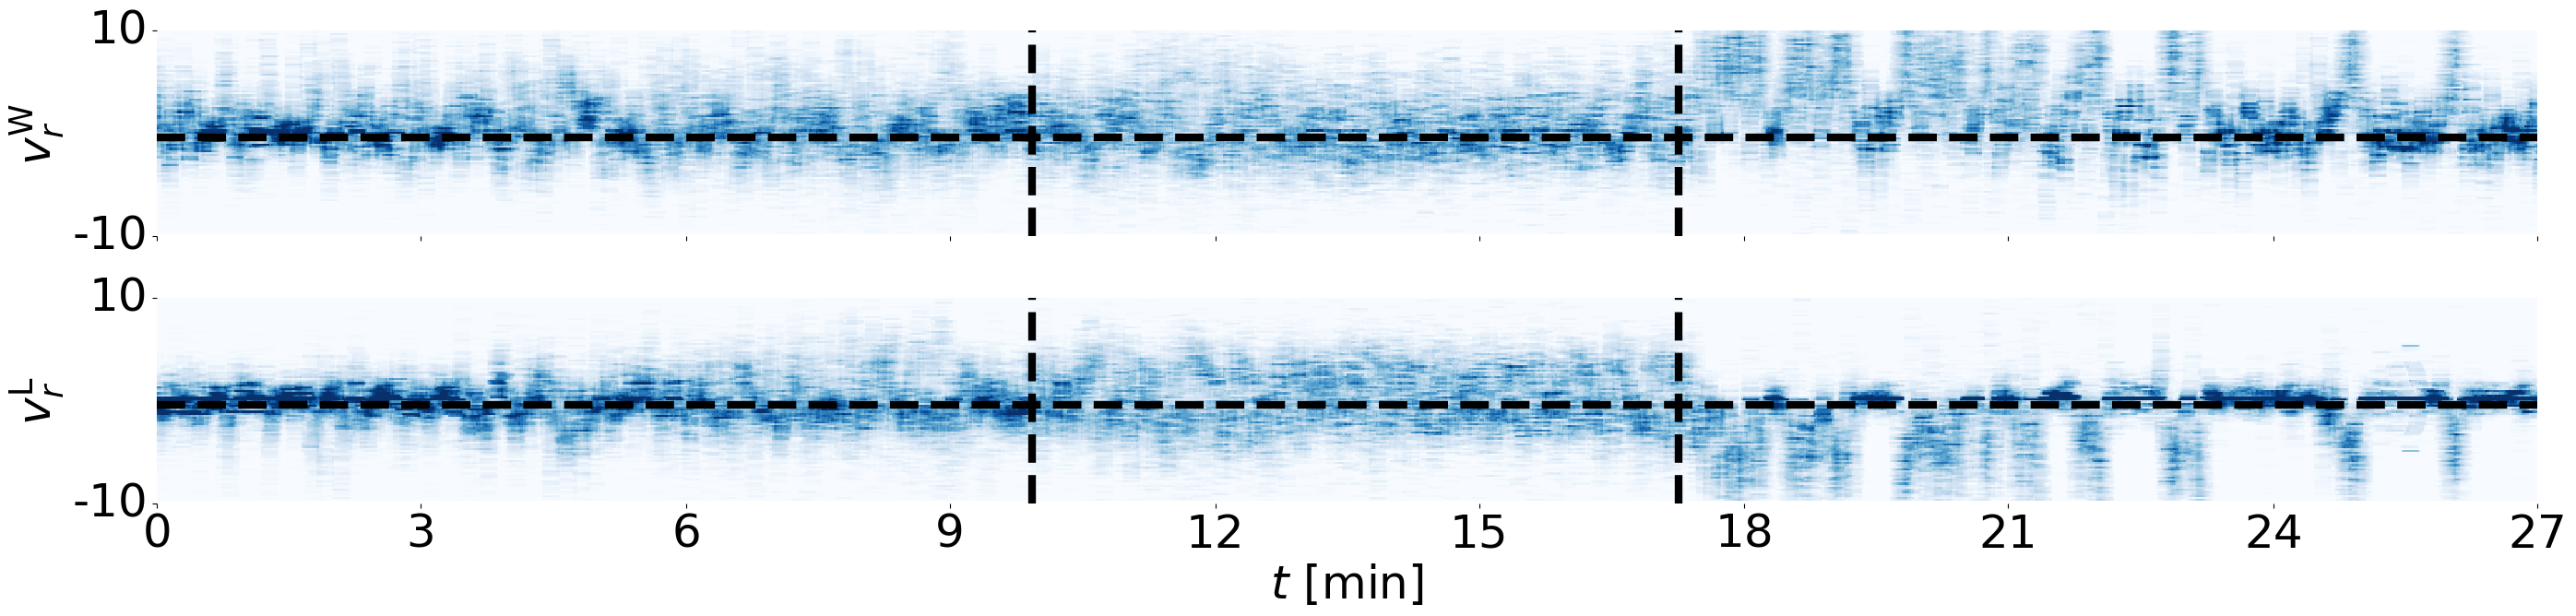

In [6]:
expid=19
# time bin params
window_size=1200
window_step=100

try:
    filename = './data/v_4_'+str(expid) # raw data
    vs = np.load(filename+'.npy',allow_pickle=1)
    fs = fight_bout_info[np.where(fight_bout_info.T[0]==expid)[0][-1]][1]
    fe = fight_bout_info[np.where(fight_bout_info.T[0]==expid)[0][-1]][2]
    vr = vs[0,fs-10*6000:fe+10*6000,0]
    numFrames = len(vr)
    vrmax = 10 
    vrmin = -vrmax
    vr_bins = np.arange(vrmin, vrmax, 0.2)
except:
    print('error')

# first make the time windows
time_windows = return_overlapping_windows_for_timeframes(numFrames, window_size=window_size, window_step=window_step)

# now compute the heatmaps of the variables that we want to plot
heatmap = compute_windowed_distribution_array_from_1D_tseries(vr, time_windows,vr_bins)
vr = vs[1,fs-10*6000:fe+10*6000,0]
heatmap2 = compute_windowed_distribution_array_from_1D_tseries(vr, time_windows,vr_bins)


cmap = 'Blues'


# --------------------_#

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(21.5*2*.7,10*.8), sharex=True)
# fig.suptitle('Windowed distributions')
fig.tight_layout(pad=3)
dpi = 400

ax = axs[0]
vmx = .05
xlab = '$t \ \mathrm{[min]}$'
ylab = '[cm]'
num_xticks = 10
num_yticks = 5
# plt_title = r'$ v^\mathrm{W}_r\  \mathrm{ [BL/s]}$'
plt_title = r'$ v^\mathrm{W}_r$'
plot_windowed_distribution_array_onto_axis(heatmap,  ax, vr_bins, time_windows,
                                           vmax=vmx, use_cbar=0, cmap=cmap, lastPanel=False, xlim=None,
                                           xlabel=xlab, ylabel=ylab, plot_title=plt_title, num_xticks=num_xticks, draw_median=False)
ax = axs[1]
# plt_title = r'$ v^\mathrm{L}_r\  \mathrm{ [BL/s]} $'
plt_title = r'$ v^\mathrm{L}_r$'
plot_windowed_distribution_array_onto_axis(heatmap2,  ax, vr_bins, time_windows,
                                           vmax=vmx, use_cbar=0, cmap=cmap, lastPanel=True, xlim=None,
                                           xlabel=xlab, ylabel=ylab, plot_title=plt_title, num_xticks=num_xticks, draw_median=False)

plt.subplots_adjust(top=0.9, hspace=0.3)
plt.show()

In [5]:
## use 10 minutes definition of epoch

lmax = 1695641 # the length of longest time-series
n_exp = 22

v_fight = np.zeros([n_exp,2,lmax,3])
v_fight[:] = np.nan

v_pre = np.zeros([n_exp,2,lmax,3])
v_pre[:] = np.nan

v_post = np.zeros([n_exp,2,lmax,3])
v_post[:] = np.nan

w = int(10*60*100)

for expid in range(n_exp):
    filename = './data/v_4_'+str(expid) # raw data
    vs = np.load(filename+'.npy',allow_pickle=1)
    for i in range(len(fight_bout_info[np.where(fight_bout_info.T[0]==expid)][:,1])):
#         print(fight_bout_info[np.where(fight_bout_info.T[0]==expid)][:,2])
        fs = fight_bout_info[np.where(fight_bout_info.T[0]==expid)][i,1]
        fe = fight_bout_info[np.where(fight_bout_info.T[0]==expid)][i,2]

        v_fight[expid,:,fs:fe,:] = vs[:,fs:fe,:]
        if i == 0: # epoch before the first fight
#             print(fs)
            t0 = np.max([fs-w,0])
            v_pre[expid,:,t0:fs,:] = vs[:,t0:fs,:]
        
        if len(fight_bout_info[np.where(fight_bout_info.T[0]==expid)][:,1])==1:
#             print(fe)
            tf = np.min([fe+w,len(vs[0,:,0])])
            v_post[expid,:,fe:tf,:] = vs[:,fe:tf,:]
        elif i==1:
#             print(fe)
            tf = np.min([fe+w,len(vs[0,:,0])])
            v_post[expid,:,fe:tf,:] = vs[:,fe:tf,:]

In [6]:
def process(inputs):
    data1, data2, k = inputs
    return pylib.crosscorrelations(data1,data2,k)[0]
def ccorr_mp(data1, data2, shifts):
    inputs = []
    for k in shifts:
        inputs.append((data1,data2,[k]))
    p = Pool(100)
    ccorr = p.map(process, inputs)
    p.close()
    return ccorr

In [7]:
def error(a):
    a = np.ma.masked_invalid(a).T
#     return np.array([np.nanstd(b)/np.sqrt(len(b.compressed())) for b in a])
    return np.array([np.nanstd(b) for b in a])



def plot_ccorr(ccorrs):
    fig = plt.figure(figsize=(5.5*1.5,4*1.5))
    plt.plot(shifts/100,np.nanmean(ccorrs,axis=0),c='k',lw=6)
    plt.plot(shifts/100,np.nanmean(ccorrs,axis=0)+error(ccorrs)/2,ls='--',c='k',lw=2)
    plt.plot(shifts/100,np.nanmean(ccorrs,axis=0)-error(ccorrs)/2,ls='--',c='k',lw=2)
    plt.fill_between(shifts/100,np.nanmean(ccorrs,axis=0)+error(ccorrs)/2,np.nanmean(ccorrs,axis=0)-error(ccorrs)/2,alpha=.4,color='gray')
    y0, y1 = -0.55, 0.2
    plt.axvline(0,c='k',lw=2)
    plt.axhline(0,c='k',lw=2)
    plt.xlim([-maxtau/100,maxtau/100])
    plt.ylim([y0,y1])
#     plt.ylabel('$\langle v_r^\\mathrm{W}(\\tau)\ v_r^\\mathrm{L} \\rangle $')
#     plt.ylabel('$C(\\tau) $')
#     plt.ylabel('$\mathrm{ccorr}_{v_r^\\mathrm{W}(\\tau)\ v_r^\\mathrm{L}}(\\tau) $')
    plt.ylabel('$C(v_r^\\mathrm{W}(\\tau),v_r^\\mathrm{L}) $',fontsize=40)
    plt.xlabel('$\\tau$ [s]')
    plt.show()

In [10]:
# fight
maxtau = 6*100
npoints = 300


ccorrs = []
shifts = np.linspace(-maxtau,maxtau,npoints,dtype=int)
for i in range(n_exp):
# for i in range(3):
    if np.sum(np.isfinite(v_fight[i,0,:,0]))==0:
        print('no fight')
        continue
#     ccorr = pylib.crosscorrelations(v_fight[i,0,:,0],v_fight[i,1,:,0],shifts)
    ccorr = ccorr_mp(v_fight[i,0,:,0],v_fight[i,1,:,0],shifts)
#     print(ccorr)
    ccorrs.append(ccorr)

no fight
no fight
no fight
no fight
no fight
no fight


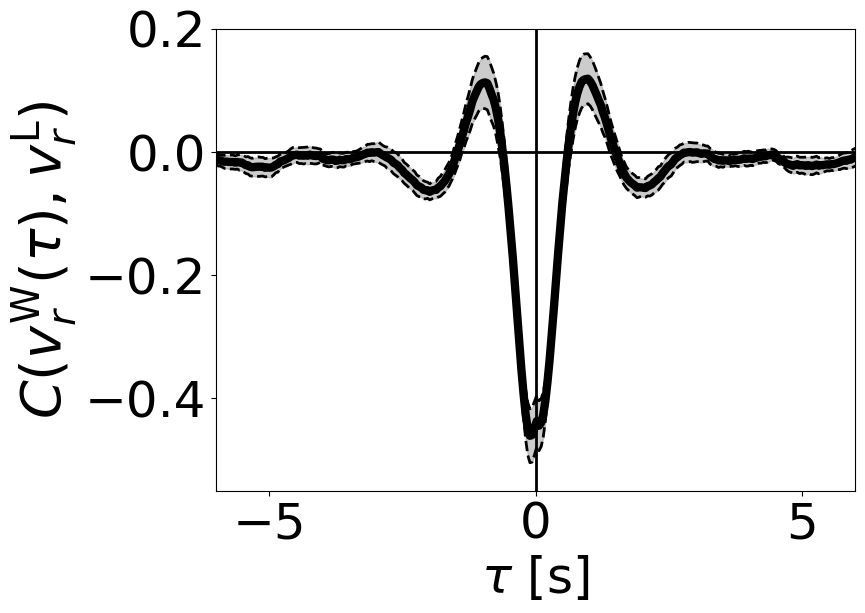

In [11]:
plot_ccorr(ccorrs)

In [12]:
# post-fight
maxtau = 6*100
npoints = 300

ccorrs_post = []
shifts = np.linspace(-maxtau,maxtau,npoints,dtype=int)
for i in range(n_exp):
# for i in range(3):
    if np.sum(np.isfinite(v_post[i,0,:,0]))==0:
        print('no fight')
        continue
#     ccorr = pylib.crosscorrelations(v_fight[i,0,:,0],v_fight[i,1,:,0],shifts)
    ccorr = ccorr_mp(v_post[i,0,:,0],v_post[i,1,:,0],shifts)
#     print(ccorr)
    ccorrs_post.append(ccorr)

no fight
no fight
no fight
no fight
no fight
no fight


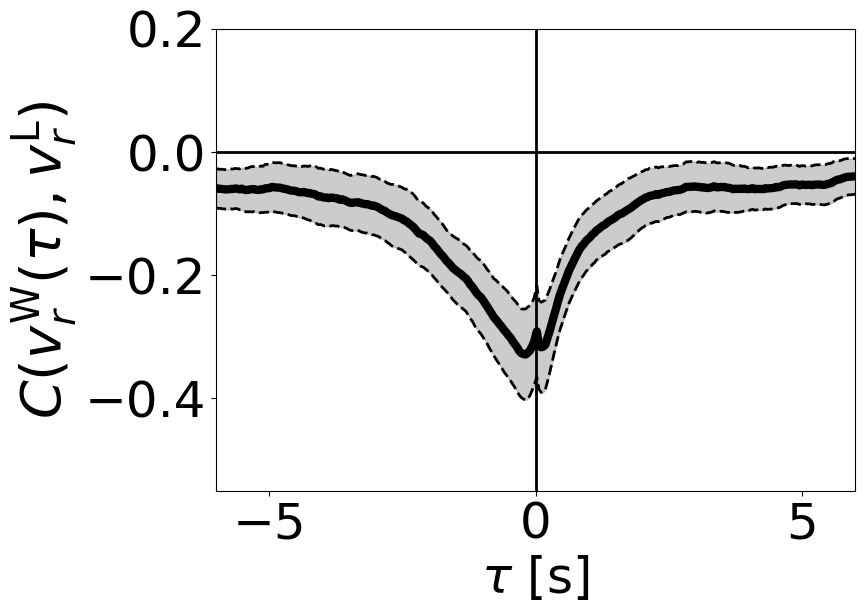

In [13]:
plot_ccorr(ccorrs_post)

In [14]:
# pre-fight

ccorrs_pre = []
shifts = np.linspace(-maxtau,maxtau,npoints,dtype=int)
for i in range(n_exp):
# for i in range(3):
    if np.sum(np.isfinite(v_pre[i,0,:,0]))==0:
        print('no fight')
        continue
#     ccorr = pylib.crosscorrelations(v_fight[i,0,:,0],v_fight[i,1,:,0],shifts)
    ccorr = ccorr_mp(v_pre[i,0,:,0],v_pre[i,1,:,0],shifts)
#     print(ccorr)
    ccorrs_pre.append(ccorr)

no fight
no fight
no fight
no fight
no fight
no fight


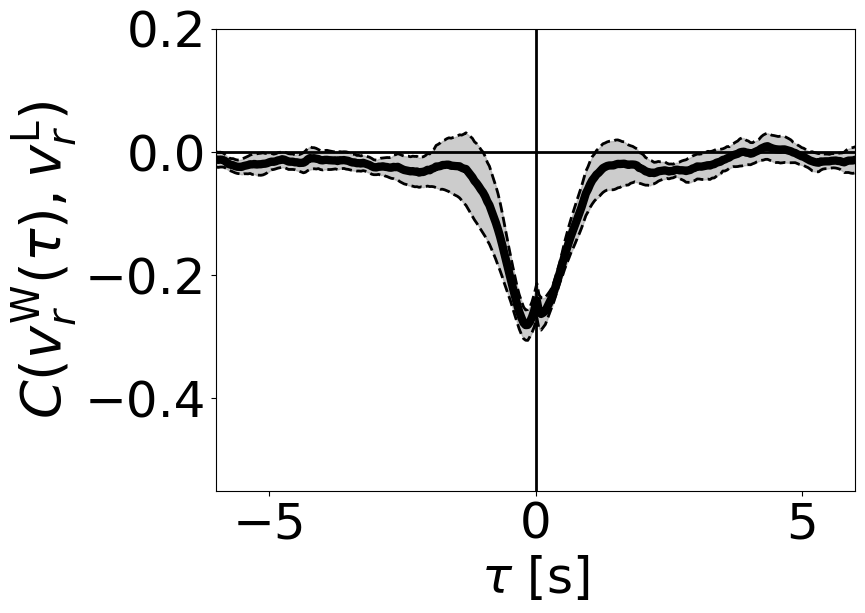

In [15]:
plot_ccorr(ccorrs_pre)

# Fig. S1
### $v_\theta$

In [9]:
def plot_ccorr(ccorrs):
    fig = plt.figure(figsize=(5.5*1.5,4*1.5))
    plt.plot(shifts/100,np.nanmean(ccorrs,axis=0),c='k',lw=6)
    plt.plot(shifts/100,np.nanmean(ccorrs,axis=0)+error(ccorrs)/2,ls='--',c='k',lw=2)
    plt.plot(shifts/100,np.nanmean(ccorrs,axis=0)-error(ccorrs)/2,ls='--',c='k',lw=2)
    plt.fill_between(shifts/100,np.nanmean(ccorrs,axis=0)+error(ccorrs)/2,np.nanmean(ccorrs,axis=0)-error(ccorrs)/2,alpha=.4,color='gray')
    y0, y1 = -0.25, 0.25
    plt.axvline(0,c='k',lw=2)
    plt.axhline(0,c='k',lw=2)
    plt.xlim([-maxtau/100,maxtau/100])
    plt.ylim([y0,y1])
    plt.ylabel('$\langle v_\\theta^\\mathrm{W}(\\tau)\ v_\\theta^\\mathrm{L} \\rangle $')
    plt.ylabel('$C(\\tau) $')
    plt.ylabel('$\mathrm{ccorr}_{v_\\theta^\\mathrm{W}(\\tau)\ v_\\theta^\\mathrm{L}}(\\tau) $')
    plt.ylabel('$C_{\langle v_\\theta^\\mathrm{W}(\\tau)v_\\theta^\\mathrm{L}\\rangle} $',fontsize=40)
    plt.ylabel('$C(v_\\theta^\\mathrm{W}(\\tau),v_\\theta^\\mathrm{L}) $',fontsize=40)

    plt.xlabel('$\\tau$ [s]')
    plt.show()

no fight
no fight
no fight
no fight
no fight
no fight


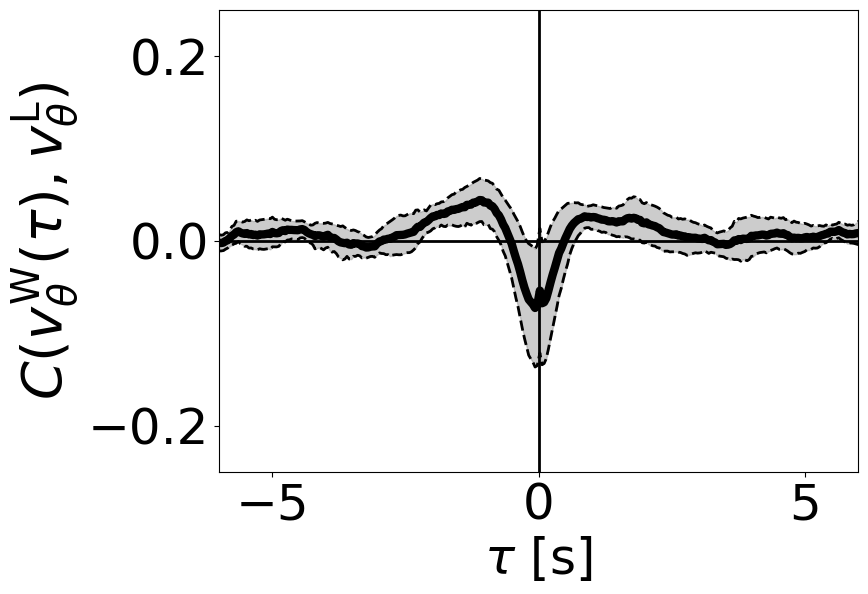

In [14]:
# v_theta in pre-fight
maxtau = 6*100
npoints = 300

ccorrs_pre = []
shifts = np.linspace(-maxtau,maxtau,npoints,dtype=int)
for i in range(n_exp):
    if np.sum(np.isfinite(v_pre[i,0,:,0]))==0:
        print('no fight')
        continue
    ccorr = ccorr_mp(v_pre[i,0,:,1],v_pre[i,1,:,1],shifts)
    ccorrs_pre.append(ccorr)
plot_ccorr(ccorrs_pre)

no fight
no fight
no fight
no fight
no fight
no fight


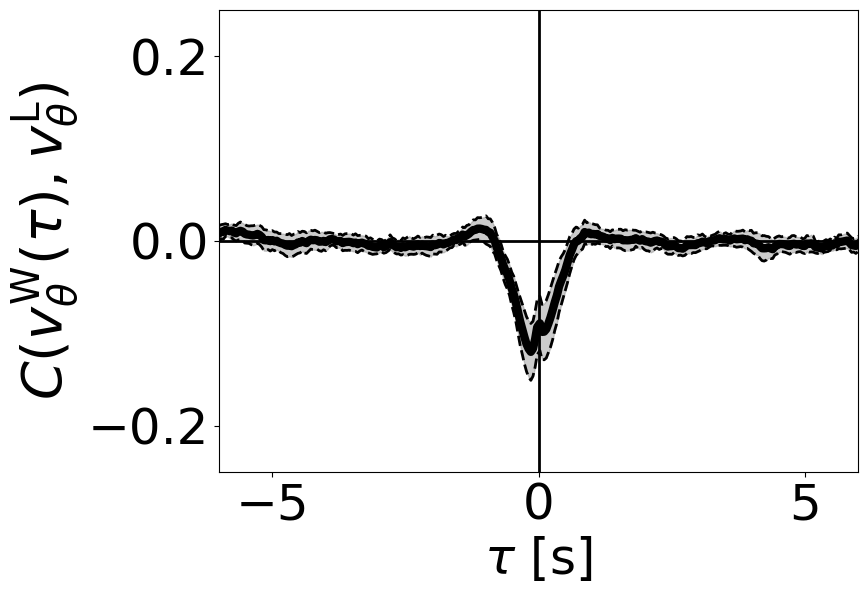

In [13]:
# fight
ccorrs = []
shifts = np.linspace(-maxtau,maxtau,npoints,dtype=int)
for i in range(n_exp):
    if np.sum(np.isfinite(v_fight[i,0,:,0]))==0:
        print('no fight')
        continue
    ccorr = ccorr_mp(v_fight[i,0,:,1],v_fight[i,1,:,1],shifts)
    ccorrs.append(ccorr)
plot_ccorr(ccorrs)

no fight
no fight
no fight
no fight
no fight
no fight


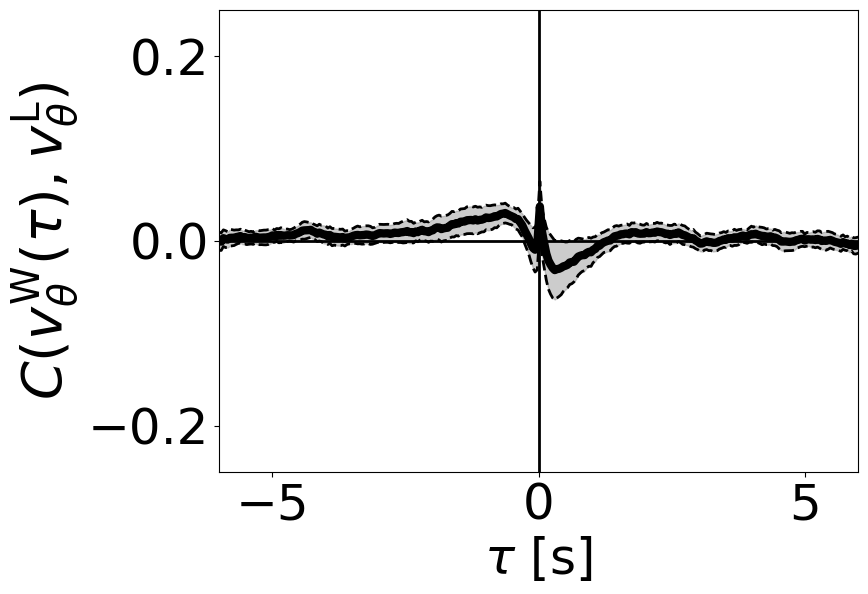

In [15]:
# post-fight
ccorrs_post = []
shifts = np.linspace(-maxtau,maxtau,npoints,dtype=int)
for i in range(n_exp):
    if np.sum(np.isfinite(v_post[i,0,:,0]))==0:
        print('no fight')
        continue
    ccorr = ccorr_mp(v_post[i,0,:,1],v_post[i,1,:,1],shifts)
    ccorrs_post.append(ccorr)
plot_ccorr(ccorrs_post)

### $v_z$

In [16]:
def plot_ccorr(ccorrs):
    fig = plt.figure(figsize=(5.5*1.5,4*1.5))
    plt.plot(shifts/100,np.nanmean(ccorrs,axis=0),c='k',lw=6)
    plt.plot(shifts/100,np.nanmean(ccorrs,axis=0)+error(ccorrs)/2,ls='--',c='k',lw=2)
    plt.plot(shifts/100,np.nanmean(ccorrs,axis=0)-error(ccorrs)/2,ls='--',c='k',lw=2)
    plt.fill_between(shifts/100,np.nanmean(ccorrs,axis=0)+error(ccorrs)/2,np.nanmean(ccorrs,axis=0)-error(ccorrs)/2,alpha=.4,color='gray')
    y0, y1 = -0.1, 0.42
    plt.axvline(0,c='k',lw=2)
    plt.axhline(0,c='k',lw=2)
    plt.xlim([-maxtau/100,maxtau/100])
    plt.ylim([y0,y1])
    plt.ylabel('$\langle v_z^\\mathrm{W}(\\tau)\ v_z^\\mathrm{L} \\rangle $')
    plt.ylabel('$C(\\tau) $')
    plt.ylabel('$\mathrm{ccorr}_{v_z^\\mathrm{W}(\\tau)\ v_z^\\mathrm{L}}(\\tau) $')
    plt.ylabel('$C_{\langle v_z^\\mathrm{W}(\\tau)v_z^\\mathrm{L}\\rangle} $',fontsize=40)
    plt.ylabel('$C(v_z^\\mathrm{W}(\\tau),v_z^\\mathrm{L}) $',fontsize=40)

    plt.xlabel('$\\tau$ [s]')
    plt.show()

no fight
no fight
no fight
no fight
no fight
no fight


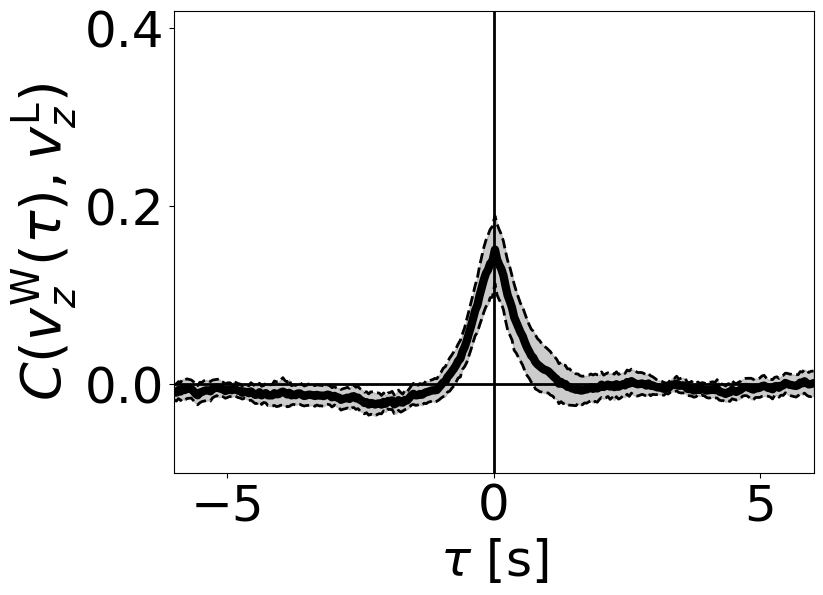

In [17]:
# pre-fight
maxtau = 6*100
npoints = 300
ccorrs_pre = []
shifts = np.linspace(-maxtau,maxtau,npoints,dtype=int)
for i in range(n_exp):
    if np.sum(np.isfinite(v_pre[i,0,:,0]))==0:
        print('no fight')
        continue
    ccorr = ccorr_mp(v_pre[i,0,:,2],v_pre[i,1,:,2],shifts)
    ccorrs_pre.append(ccorr)
plot_ccorr(ccorrs_pre)

no fight
no fight
no fight
no fight
no fight
no fight


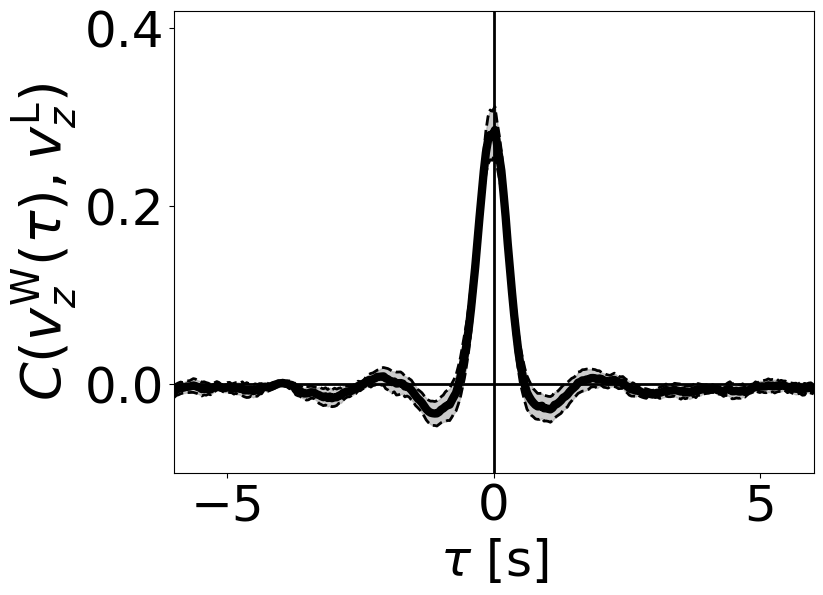

In [18]:
# fight
ccorrs = []
shifts = np.linspace(-maxtau,maxtau,npoints,dtype=int)
for i in range(n_exp):
    if np.sum(np.isfinite(v_fight[i,0,:,0]))==0:
        print('no fight')
        continue
    ccorr = ccorr_mp(v_fight[i,0,:,2],v_fight[i,1,:,2],shifts)
    ccorrs.append(ccorr)
plot_ccorr(ccorrs)

no fight
no fight
no fight
no fight
no fight
no fight


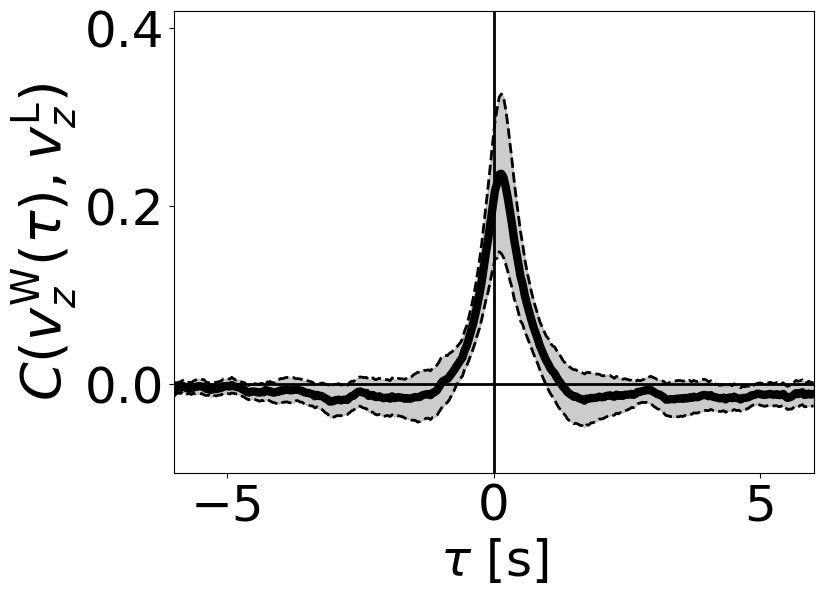

In [19]:
# post-fight
ccorrs_post = []
shifts = np.linspace(-maxtau,maxtau,npoints,dtype=int)
for i in range(n_exp):
    if np.sum(np.isfinite(v_post[i,0,:,0]))==0:
        print('no fight')
        continue
    ccorr = ccorr_mp(v_post[i,0,:,2],v_post[i,1,:,2],shifts)
    ccorrs_post.append(ccorr)
plot_ccorr(ccorrs_post)